# Feature Selection

## Overview

This notebook selects the most informative features for the classification task, using only the training data to avoid data leakage. The number of features and the selection method are defined in `config.toml`.

**Key steps:**

- Load processed data from preprocessing
- Fit feature selection on training data only
- Apply selected features to both train and test sets
- Visualize feature importances and selection results
- Save reduced datasets and selection info for modeling

**Why feature selection?**

- Reduces overfitting
- Improves model interpretability
- Speeds up training and inference
- Can improve model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import toml
import sys
sys.path.append(str(Path().resolve()))
from model_training import feature_selection

# Load config
config = toml.load('../config.toml')
fs_config = config['feature_selection']
n_features = fs_config.get('n_features', 50)
method = fs_config.get('method', 'model_importance')
scoring = fs_config.get('scoring', 'f_classif')

print(f"Feature selection method: {method}")
print(f"Number of features to select: {n_features}")
print(f"Scoring/model: {scoring}")

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])

Feature selection method: select_k_best
Number of features to select: 10
Scoring/model: f_classif


In [2]:
# Load processed data from previous step
data_dir = Path('../data/processed')
with open(data_dir / '03_processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_train = pd.DataFrame(processed_data['X_train'], columns=processed_data['feature_cols'])
X_test = pd.DataFrame(processed_data['X_test'], columns=processed_data['feature_cols'])
y_train = processed_data['y_train']
y_test = processed_data['y_test']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (137, 2095)
Test set shape: (35, 2095)


## Feature Selection Strategy

We will fit the feature selection method **only on the training data** to avoid data leakage. The selected features will then be used to filter both the training and test sets.

**Supported methods:**

- `select_k_best`: Univariate feature selection (requires `scoring`)
    - `f_classif`: ANOVA F-value
    - `mutual_info`: Mutual information
- `model_importance`: Model-based (e.g., Random Forest)
- `variance`: Variance threshold (not supervised)
- `rfe`, `lasso`, etc. (future extensions)

## 🚨 Attention

The figures and results below are the results by applying feature selection on all training samples for a good understanding of the data. This result won't be passed to the model training directly. Instead, this feature selection method with the defined parameters will be applied independently for each cross validation and the test set. The selected feature might be different each time.

In [3]:
feature_scores, selected_features, importance_type = feature_selection(X_train, y_train, method, scoring, n_features)

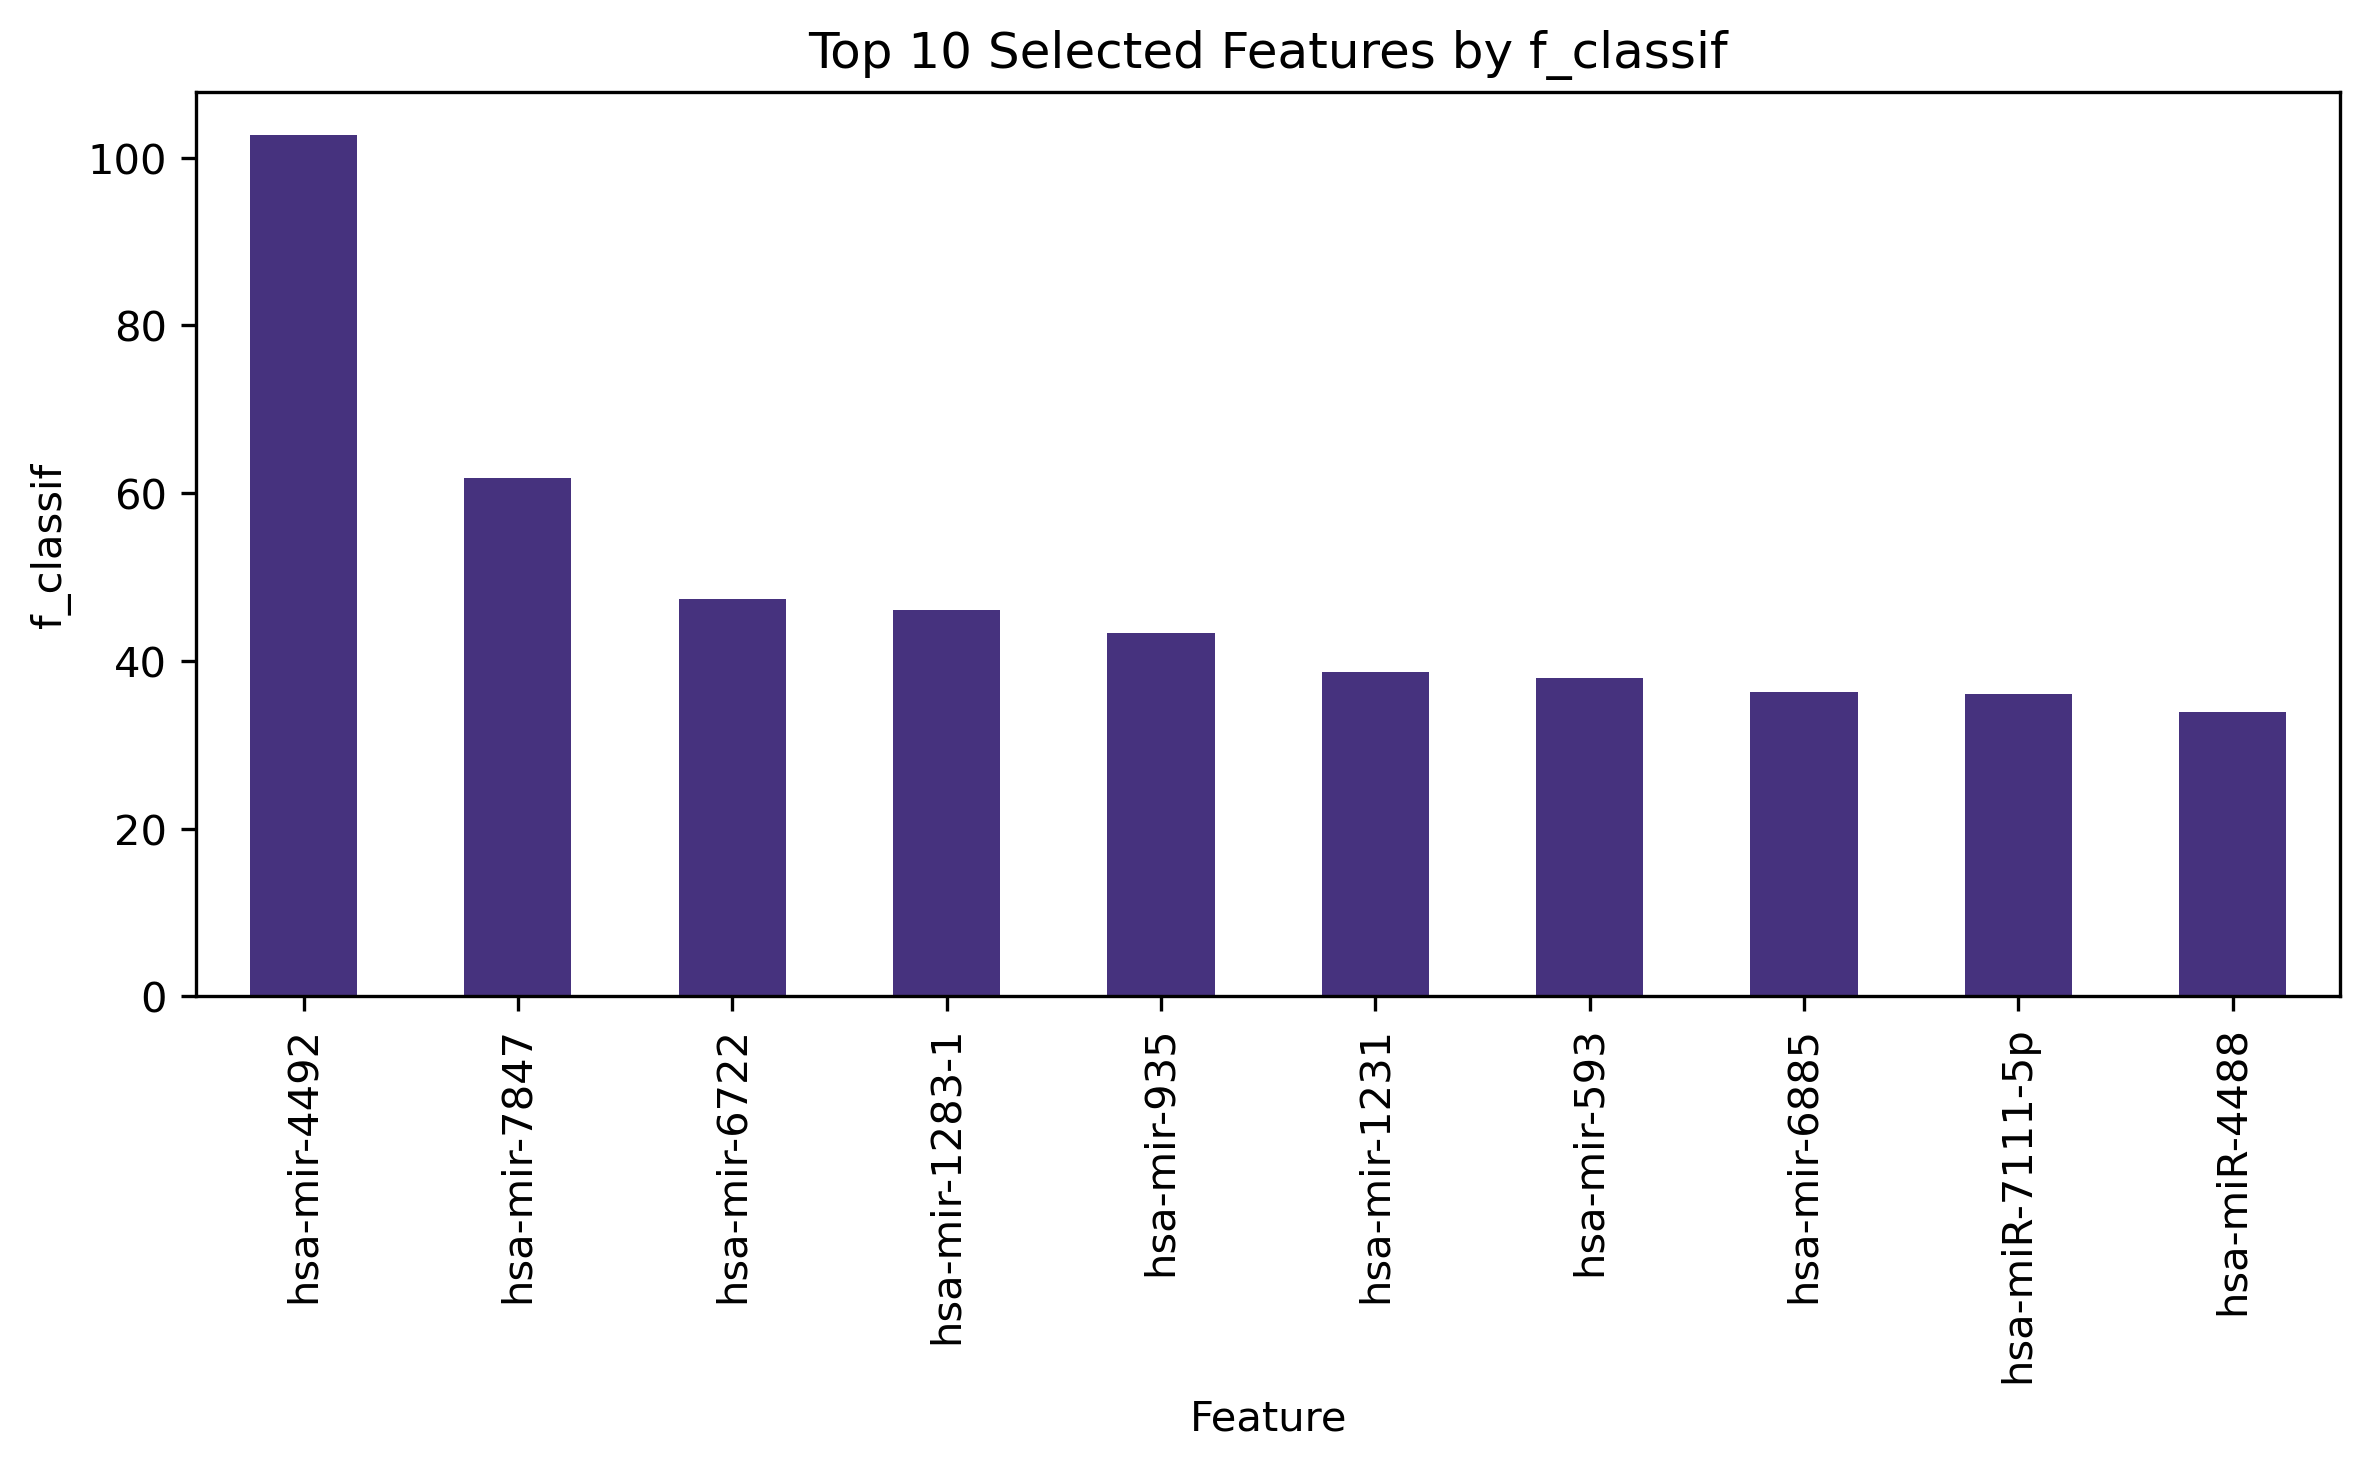

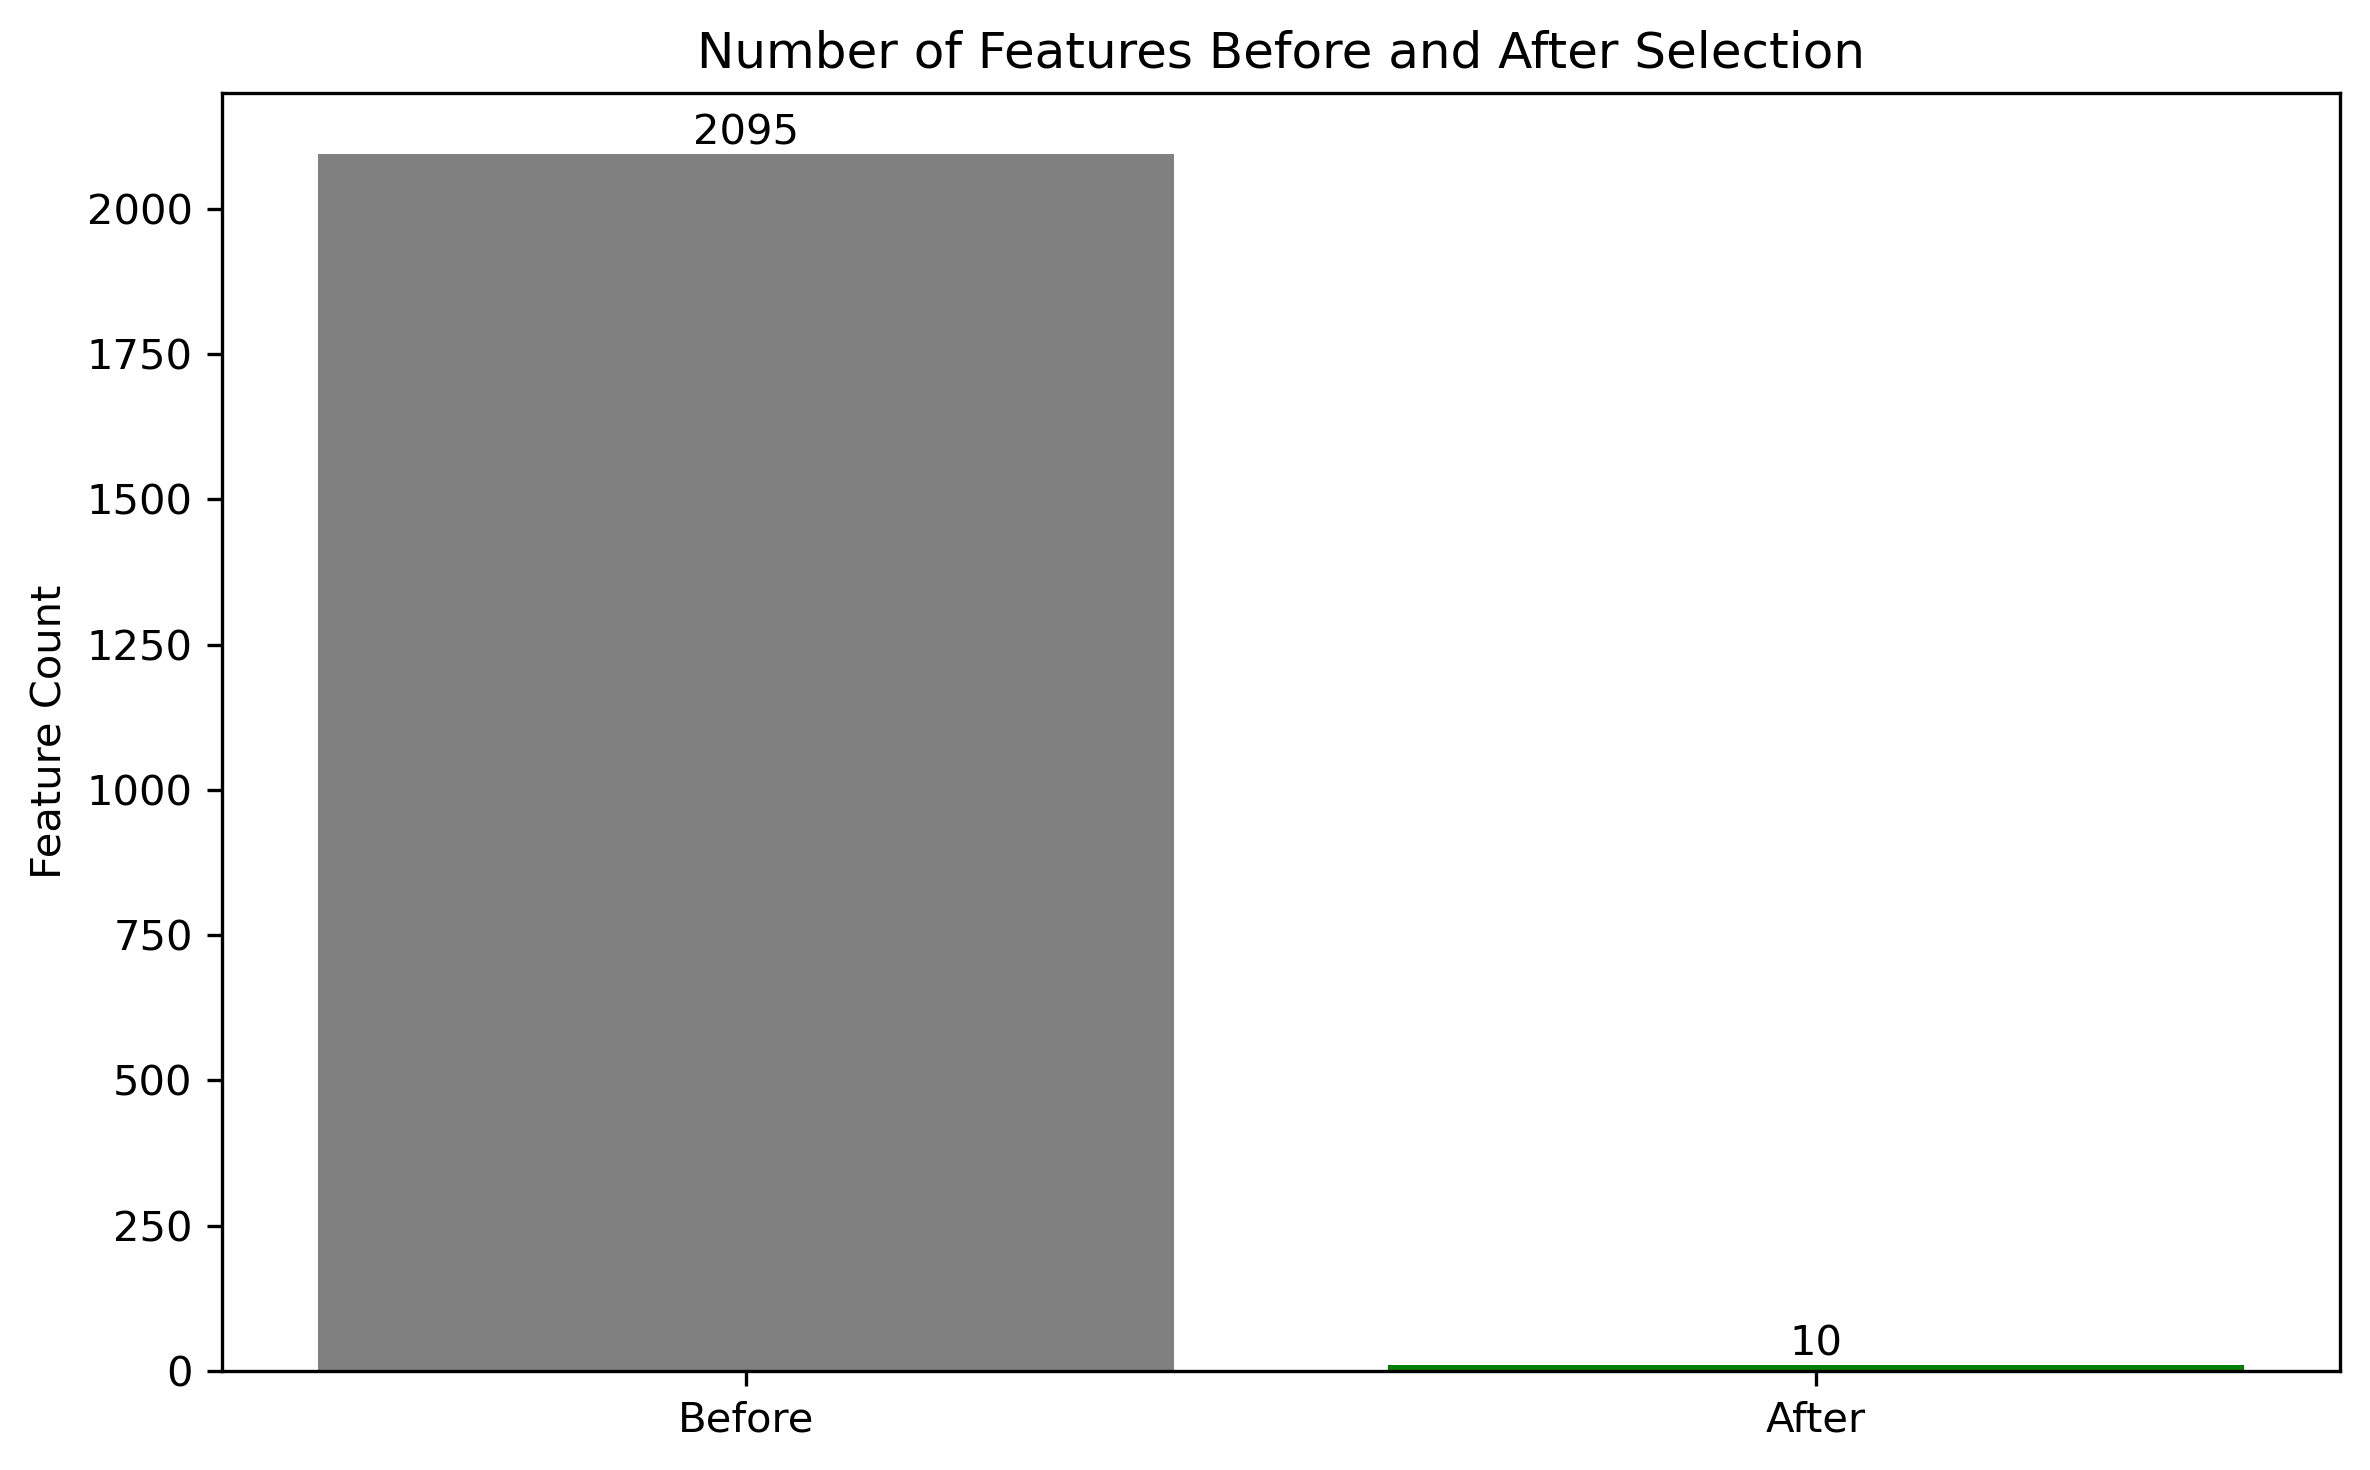

In [4]:
# Visualize feature importances
plt.figure()
top_n = min(30, len(selected_features))
feature_scores[selected_features].sort_values(ascending=False)[:top_n].plot(kind='bar')
plt.title(f"Top {top_n} Selected Features by {importance_type}")
plt.ylabel(importance_type)
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Visualize before/after feature count
before = X_train.shape[1]
after = len(selected_features)

plt.figure()
bars = plt.bar(['Before', 'After'], [before, after], color=['gray', 'green'])
plt.title("Number of Features Before and After Selection")
plt.ylabel("Feature Count")

# Add number labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1,  # +1 = offset
             str(int(height)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

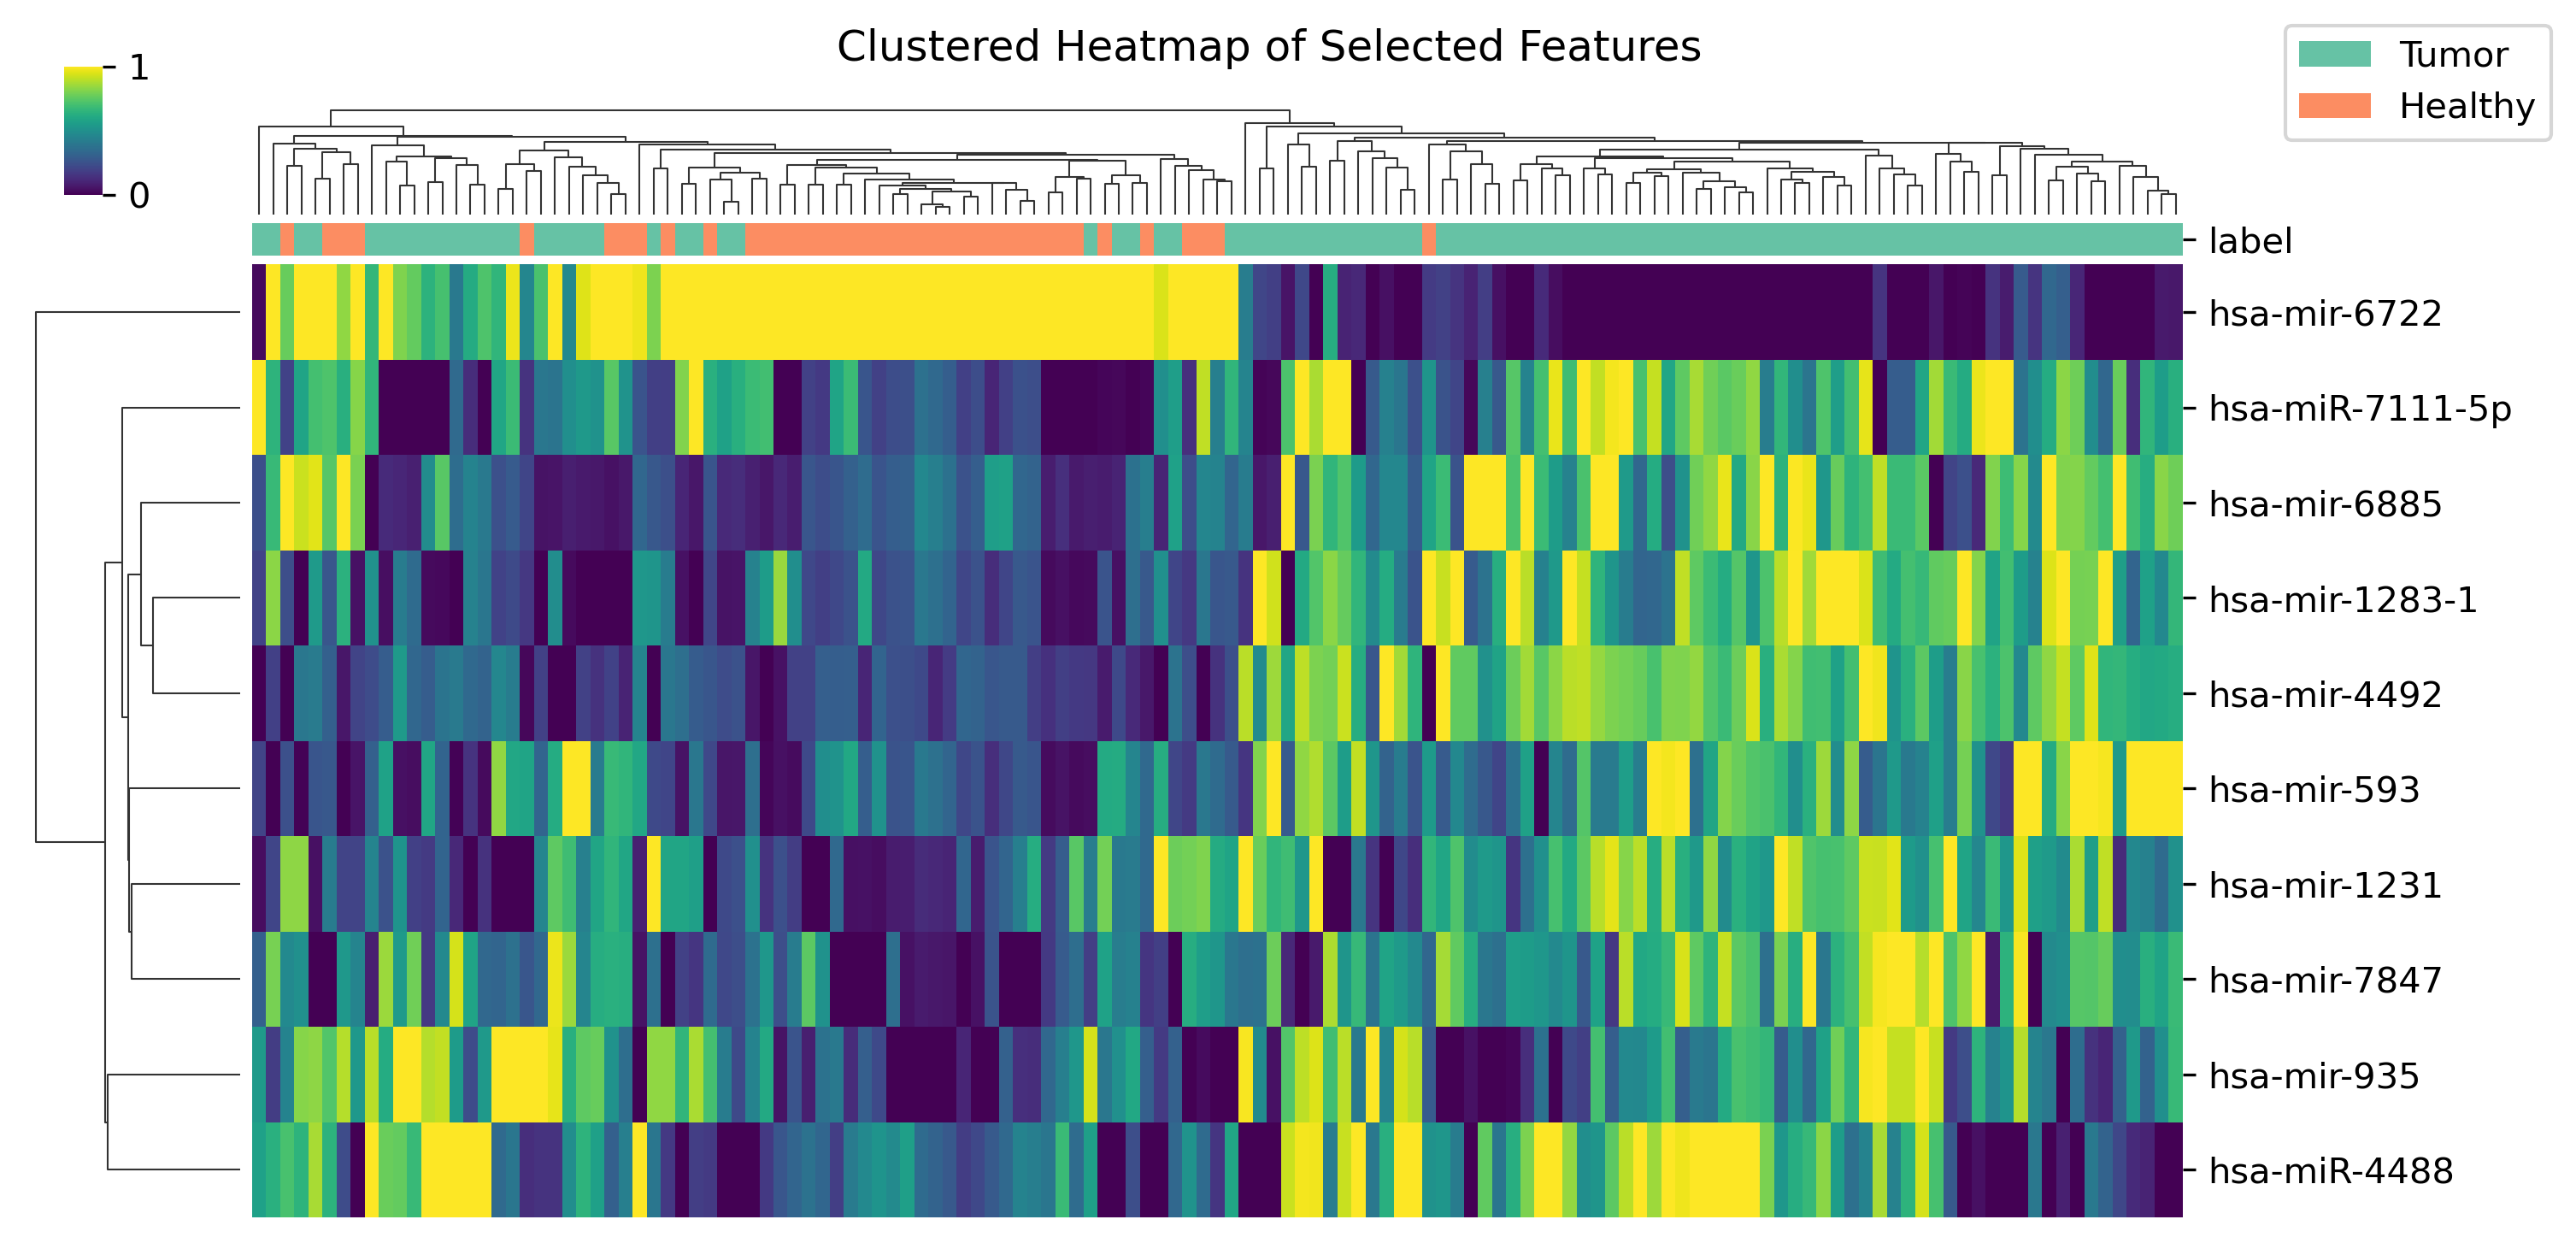

In [5]:
# Prepare data
data = X_train[selected_features]
data.index = processed_data["train_indices"]
labels = y_train.loc[data.index]

# Map class labels to colors
palette = sns.color_palette("Set2", n_colors=labels.nunique())
label_to_color = dict(zip(labels.unique(), palette))
col_colors = labels.map(label_to_color)

# Plot clustered heatmap
g = sns.clustermap(data.T,
                   cmap='viridis',
                   figsize=(10, 5),
                   standard_scale=1,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=col_colors,              # ← annotate columns by y_train
                   dendrogram_ratio=(0.1, 0.1),       # ← shrink top dendrogram
                   cbar_pos=(0.03, 0.9, 0.015, 0.1))    # ← top-left, narrow & separated
# Hide x-axis ticks and labels
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xticklabels([])
# Fix title and layout
g.fig.suptitle("Clustered Heatmap of Selected Features", y=1.03)

# Optional: Add legend for labels
for label, color in label_to_color.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="right", ncol=1, bbox_to_anchor=(1.2, 1.2))

plt.show()

In [6]:
# Save reduced datasets and feature selection info
output = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'method': method,
    'scoring': scoring,
    'n_features': n_features,
    'feature_selection': feature_selection
}

with open(data_dir / '04_feature_selection.pkl', 'wb') as f:
    pickle.dump(output, f)

print("Feature selection results saved to 04_feature_selection.pkl")

Feature selection results saved to 04_feature_selection.pkl


## Summary

- Selected the top features using **only the training data** and the method specified in `config.toml`
- Visualized feature importances and the effect of selection
- Saved the reduced datasets and selection info for modeling

**Next:**  
Proceed to model training using only the selected features for both training and test sets.